## DSCI 100 Group Project Proposal ##

By: Alessandra Lu, Ruby Suo, Han Wei, Alan Wu

#### Introduction ####

**Question:** 

#### Preliminary Exploratory Data Analysis ####

In [1]:
# Import libraries

library(tidyverse)
library(repr)
library(tidymodels)
library(dbplyr)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# Load data from the web

url <- "https://raw.githubusercontent.com/alan-w-u/dsci-100-group-project/main/student-mat.csv"
data_raw <- read_delim(url, delim = ";")
data_raw

Rows: 395 Columns: 33
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (17): school, sex, address, famsize, Pstatus, Mjob, Fjob, reason, guardi...
dbl (16): age, Medu, Fedu, traveltime, studytime, failures, famrel, freetime...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
MS,M,21,R,GT3,T,1,1,other,other,⋯,5,5,3,3,3,3,3,10,8,7
MS,M,18,R,LE3,T,3,2,services,other,⋯,4,4,1,3,4,5,0,11,12,10
MS,M,19,U,LE3,T,1,1,other,at_home,⋯,3,2,3,3,3,5,5,8,9,9


In [53]:
# Clean and wrangle the data

age_range = c(15, 16, 17, 18)

data <- data_raw |>
    filter(age %in% age_range & G3 != 0) |> # Filter for student age that is normatively in secondary school and final grade is 0
    select(sex, age, traveltime, studytime, paid, activities, freetime, goout, absences, G3) |>
    rename(finalgrade = G3) |>
    mutate(finalgrade = finalgrade * 5)
data

sex,age,traveltime,studytime,paid,activities,freetime,goout,absences,finalgrade
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
F,18,2,2,no,no,3,4,6,30
F,17,1,2,no,no,3,3,4,30
F,15,1,2,yes,no,3,2,10,50
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
F,18,1,2,yes,no,3,4,0,40
M,17,2,1,no,no,4,5,3,80
M,18,3,1,no,no,4,1,0,50


In [54]:
# Split training and testing data

data_split <- initial_split(data, prop = 0.7, strata = finalgrade)
data_training <- training(data_split)
data_testing <- testing(data_split)

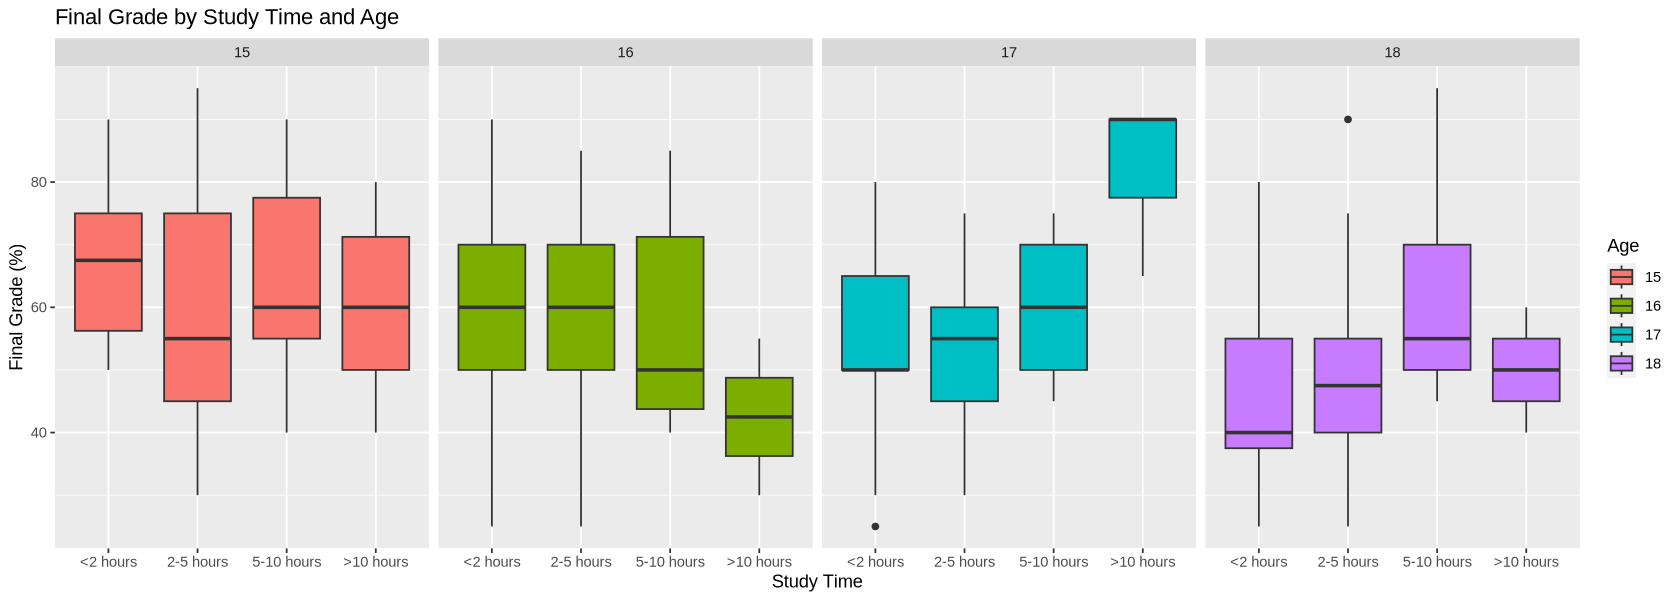

In [74]:
# Visualize data

options(repr.plot.height = 5, repr.plot.width = 14)

studytime_values <- c("1", "2", "3", "4")
studytime_meanings <- c("<2 hours", "2-5 hours", "5-10 hours", ">10 hours")

data_plot <- data_training |>
    ggplot(aes(x = as_factor(studytime), y = finalgrade, fill = as_factor(age))) +
    geom_boxplot() +
    labs(x = "Study Time", y = "Final Grade (%)", fill = "Age") +
    ggtitle("Final Grade by Study Time and Age") +
    facet_grid(cols = vars(as_factor(age))) +
    scale_x_discrete(breaks = studytime_values, labels = studytime_meanings)
data_plot

#### Methods ####

The variables we will use from the data set are:
- sex
- age
- travel time
- study time
- free time
- extra paid classes in subject matter
- extracurriculars
- how much they go out with friends
- absences

#### Expected Outcomes and Significance ####